In [60]:
from functools import partial
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
#import torch.nn as nn
#import torch.utils.data as data

import time
from itertools import product

import pyro
#import pyro.distributions as dist

import tyxe

In [6]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen 
#import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from jax.flatten_util import ravel_pytree


import jax_dataloader.core as jdl

import rebayes
from rebayes import base
from rebayes.utils import uci_regression_data, datasets
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd

# Data

In [7]:
X_train, Y_train, X_test, Y_test, task_id_train, task_id_test = rebayes.utils.datasets.make_1d_regression_sequence(n_dist=5)

def get_task_data(i):
    ndx_train = (task_id_train == i)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
    ndx_test = (task_id_test == i)
    Xte, yte = X_test[ndx_test], Y_test[ndx_train]
    return Xtr, ytr, Xte, yte


Xtr, ytr, Xte, yte = get_task_data(0)


In [8]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl=''):
    plt.figure()
    plt.plot(Xtr, ytr, 'o', color="black", label='train')
    plt.plot(Xte, yte, 'x', color="red", label='test')
    plt.plot(Xte, yhat, '*', color="blue", label='pred')
    plt.legend()
    plt.title(ttl)



# Rebayes

In [18]:
class MLP(flax.linen.Module):
    n_out: int
    activation: Callable = flax.linen.tanh
    
    @flax.linen.compact
    def __call__(self, x):
        x = flax.linen.Dense(50)(x)
        x = self.activation(x)
        x = flax.linen.Dense(self.n_out)(x)
        return x

def make_bnn_flax():    
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    #print(n_params)
    return model, flat_params, recfn



151


Text(0.5, 0, 'batch')

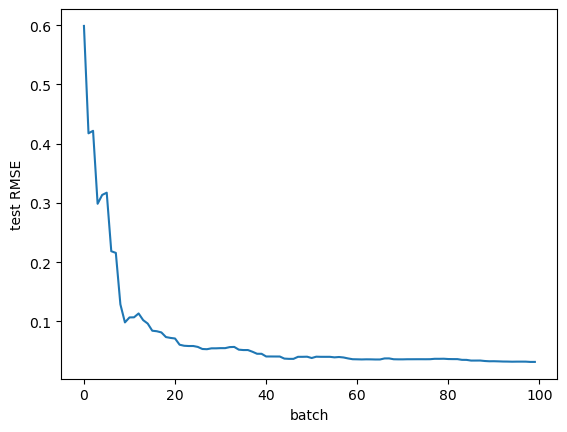

In [41]:
model, flat_params, recfn = make_bnn_flax()

def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=recfn)

params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1,
        dynamics_weights=1,
        dynamics_covariance=0,
        emission_mean_function=apply_fn,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
    )

Xtr, ytr, Xte, yte = get_task_data(0)
Xtr_jax, ytr_jax, Xte_jax, yte_jax = jnp.array(Xtr), jnp.array(ytr), jnp.array(Xte), jnp.array(yte)


def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    yhat = apply_fn(bel.mean, Xte_jax).squeeze()
    rmse = jnp.mean(jnp.square(yhat - yte_jax[:,0]))
    return rmse



In [ ]:
method_list = ['']

method = "lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    steady_state=True,
)
estimator = lofi.RebayesLoFi(params, params_lofi, method=method)


estimator = ekf.RebayesEKF(params, method='fcekf')
bel, test_rmse_list = estimator.scan(Xtr_jax, ytr_jax, progress_bar=False, callback=callback)


plt.figure()
plt.plot(test_rmse_list)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')

yhat = apply_fn(bel.mean, Xte_jax).squeeze()
ysd = []
plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl='fcekf')

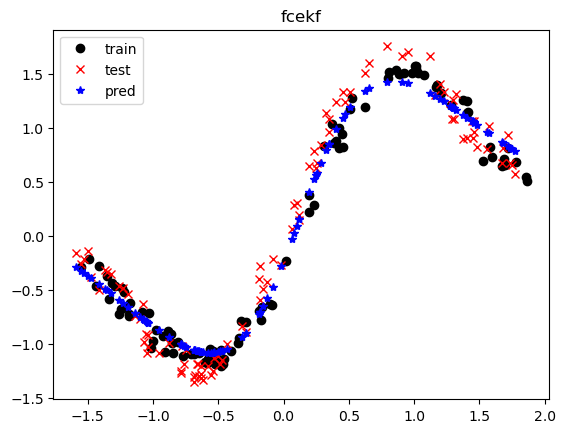

In [42]:
yhat = apply_fn(bel.mean, Xte_jax).squeeze()
ysd = []
plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl='fcekf')


# Tyxe

In [52]:
def make_bnn_tyxe():
    nhidden = 50
    net = torch.nn.Sequential(torch.nn.Linear(1, nhidden), torch.nn.Tanh(), torch.nn.Linear(nhidden, 1))
    prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))
    #obs_model = tyxe.likelihoods.HomoskedasticGaussian(Ntr, scale=0.1)
    obs_model = tyxe.likelihoods.HomoskedasticGaussian(1, scale=0.1)
    guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
    #guide = partial(pyro.infer.autoguide.guides.AutoLowRankMultivariateNormal, init_scale=0.01, rank=10)
    bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)
    return bnn

def train_bnn_tyxe(bnn, loader, nepochs=100, lr=1e-3):
    #pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": lr})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)
        
    with tyxe.poutine.local_reparameterization():
        bnn.fit(loader, optim, nepochs, callback)
    return bnn, elbos

def update_prior_tyxe(bnn):
    bayesian_weights = tyxe.util.pyro_sample_sites(bnn)
    posteriors = bnn.net_guide.get_detached_distributions(bayesian_weights)
    bnn.update_prior(tyxe.priors.DictPrior(posteriors))
    return bnn

In [73]:


def scan_tyxe(Xtr, ytr, Xte, yte, batch_size, nepochs_per_batch=100, lr=1e-3):
    pyro.clear_param_store()
    bnn = make_bnn_tyxe()
    Ntr = Xtr.shape[0]
    if type(Xte) is not torch.Tensor: Xte = torch.tensor(Xte)
    if type(yte) is not np.ndarray: yte = yte.detach().numpy()
    nbatches = int(Ntr/batch_size)
    outputs = []
    for b in range(nbatches):
        #print('batch {:d} of {:d}'.format(b, nbatches))
        ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
        Xb, yb = Xtr[ndx_train], ytr[ndx_train]
        dataset = torch.utils.data.TensorDataset(Xtr, ytr)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        bnn, elbos = train_bnn_tyxe(bnn, loader, nepochs_per_batch, lr)
        yhat, ysd = bnn.predict(Xte, num_predictions=32)
        yhat, ysd = yhat.detach().numpy(), ysd.detach().numpy()
        rmse = np.mean(np.square(yte - yhat))
        outputs.append(rmse)
        bnn = update_prior_tyxe(bnn)
    return np.array(outputs), yhat, ysd

In [ ]:
Xtr, ytr, Xte, yte = get_task_data(0)
Xtr_pt, ytr_pt, Xte_pt, yte_pt = torch.tensor(Xtr), torch.tensor(ytr), torch.tensor(Xte), torch.tensor(yte)

In [57]:

def run_tyxe(batch_size=10, nepochs_per_batch=100, lr=1e-3):
    pyro.set_rng_seed(42)
    t0 = time.time()
    test_rmse_list, yhat, ysd = scan_tyxe(Xtr_pt, ytr_pt, Xte_pt, yte_pt, batch_size, nepochs_per_batch, lr)
    t1 = time.time()
    elapsed_time = t1-t0

    ndx = np.arange(0, 100, step=10)
    plt.figure()
    plt.plot(ndx, test_rmse_list)
    plt.ylabel('test RMSE')
    plt.xlabel('num. observations')
    plt.title(ttl)

    ttl = 'bs {:d}, nepochs {:d}, lr {:0.2f}'.format(batch_size, nepochs_per_batch, lr, elapsed_time)
    plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl=ttl)





[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]
CPU times: user 1min 1s, sys: 1.58 s, total: 1min 2s
Wall time: 1min 2s


In [71]:

bs_list = [10]
nepoch_list = [1, 10, 100]
lr_list = [1e-3, 1e-2]
hparams_list = []

for i, (bs, nepochs, lr) in enumerate(product(bs_list, nepoch_list, lr_list)):
    hparam_dict = {'bs': bs, 'nepochs': nepochs, 'lr': lr}
    hparams_list.append(hparam_dict)

print(hparams_list)


[{'bs': 10, 'nepochs': 1, 'lr': 0.001}, {'bs': 10, 'nepochs': 1, 'lr': 0.01}, {'bs': 10, 'nepochs': 10, 'lr': 0.001}, {'bs': 10, 'nepochs': 10, 'lr': 0.01}, {'bs': 10, 'nepochs': 100, 'lr': 0.001}, {'bs': 10, 'nepochs': 100, 'lr': 0.01}]


In [72]:
rmse_trace_list, elapsed_list, yhat_list  = [], [], []
for i, hparams in enumerate(hparams_list): 
    print(hparams)  
    pyro.set_rng_seed(42)
    t0 = time.time()
    rmse_trace, yhat, ysd = scan_tyxe(Xtr_pt, ytr_pt, Xte_pt, yte_pt, hparams['bs'], hparams['nepochs'], hparams['lr'])
    yhat_list.append(yhat)
    t1 = time.time()
    elapsed = t1-t0
    print(rmse_trace)
    rmse_trace_list.append(rmse_trace)
    elapsed_list.append(elapsed)



{'bs': 10, 'nepochs': 1, 'lr': 0.001}
batch 0 of 10
batch 1 of 10
batch 2 of 10
batch 3 of 10
batch 4 of 10
batch 5 of 10
batch 6 of 10
batch 7 of 10
batch 8 of 10
batch 9 of 10
1.081308126449585 [0.6171897  0.5559806  0.53555167 0.5024019  0.47206715 0.45725304
 0.4452206  0.42502978 0.42012906 0.4078023 ]
{'bs': 10, 'nepochs': 1, 'lr': 0.01}
batch 0 of 10
batch 1 of 10
batch 2 of 10
batch 3 of 10
batch 4 of 10
batch 5 of 10
batch 6 of 10
batch 7 of 10
batch 8 of 10
batch 9 of 10
1.057952880859375 [0.44296086 0.36774552 0.34640622 0.38425785 0.34866676 0.38624382
 0.3514588  0.38720176 0.3523936  0.39088595]
{'bs': 10, 'nepochs': 10, 'lr': 0.001}
batch 0 of 10
batch 1 of 10
batch 2 of 10
batch 3 of 10
batch 4 of 10
batch 5 of 10
batch 6 of 10
batch 7 of 10
batch 8 of 10
batch 9 of 10
6.649609327316284 [0.34373707 0.34340426 0.344086   0.34363243 0.34398133 0.3435089
 0.34311122 0.34326017 0.3437072  0.34338152]
{'bs': 10, 'nepochs': 10, 'lr': 0.01}
batch 0 of 10
batch 1 of 10
batch 2 

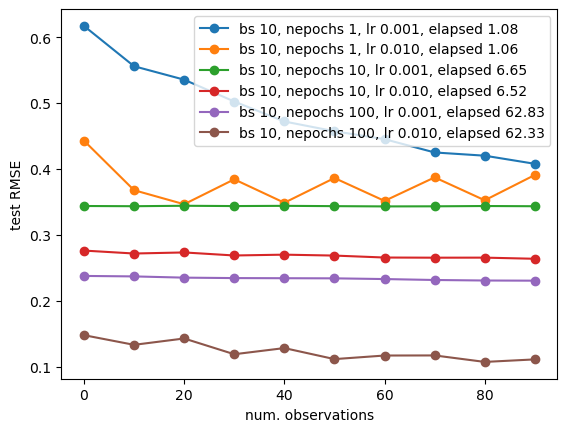

In [77]:
ndx = np.arange(0, 100, step=10)
plt.figure()
for i in range(len(hparams_list)):
    hparams = hparams_list[i]
    ttl = 'bs {:d}, nepochs {:d}, lr {:0.3f}, elapsed {:0.2f}'.format(hparams['bs'], hparams['nepochs'], hparams['lr'], elapsed_list[i])
    plt.plot(ndx, rmse_trace_list[i], 'o-', label=ttl)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')
plt.legend()


5


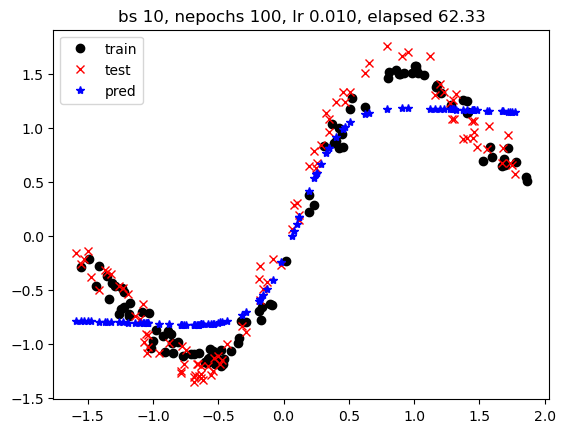

In [75]:
print(i)
hparams = hparams_list[i]
ttl = 'bs {:d}, nepochs {:d}, lr {:0.3f}, elapsed {:0.2f}'.format(hparams['bs'], hparams['nepochs'], hparams['lr'], elapsed_list[i])
plot_pred(Xtr, ytr, Xte, yte, yhat, ysd=[], ttl=ttl)


# Junk

In [14]:
X_train, Y_train, X_test, Y_test, task_id_train, task_id_test = rebayes.utils.datasets.make_1d_regression_sequence(n_dist=5)

def get_task_data(i):
    ndx_train = (task_id_train == i)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
    ndx_test = (task_id_test == i)
    Xte, yte = X_test[ndx_test], Y_test[ndx_train]
    return Xtr, ytr, Xte, yte


Xtr, ytr, Xte, yte = get_task_data(0)

def get_task_data_loader(i):
    ndx_train = (task_id_train == i)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
    ndx_test = (task_id_test == i)
    Xte, yte = X_test[ndx_test], Y_test[ndx_train]

    dataset = data.TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
    Ntr  = Xtr.shape[0] # full batch
    loader = data.DataLoader(dataset, batch_size=Ntr)
    return Xtr, ytr, Xte, yte, loader


def get_batch_data(b, task, batch_size):
    Xtr, ytr, Xte, yte, train_loader = get_task_data(task)

    ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
    print(ndx_train)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
 
    dataset = data.TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
    Ntr  = Xtr.shape[0] # full batch
    loader = data.DataLoader(dataset, batch_size=Ntr)
    return Xtr, ytr, Xte, yte, loader



In [ ]:
def rebayes_scan(Xtr, ytr, Xte, yte, batch_size):
    bnn = make_bnn()
    Ntr = Xtr.shape[0]
    nbatches = int(Ntr/batch_size)
    outputs = []
    for b in range(nbatches):
        ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
        Xb, yb = Xtr[ndx_train], ytr[ndx_train]
        dataset = data.TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
        loader = data.DataLoader(dataset, batch_size=batch_size)
        bnn, elbos = train_bnn(bnn, loader, nepochs)
        if type(Xte) is not torch.Tensor: Xte = torch.tensor(Xte)
        yhat, ysd = bnn.predict(Xte, num_predictions=32)
        out = batch_callback(b, Xtr, ytr, Xte, yte, yhat, ysd)
        outputs.append(out)
        bnn = update_prior(bnn)
    return outputs

In [15]:
Xtr, ytr, Xte, yte, train_loader = get_task_data(0)
dataset = data.TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
train_dl = jdl.DataLoader(dataset, 'pytorch', batch_size=5, shuffle=False)

(Xi,Yi) = next(iter(train_dl))
print(Xi.shape, Yi.shape)

(5,) (5,)


/home/kpmurphy/mambaforge/lib/python3.10/site-packages/jax_dataloader/core.py:164: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(batch)
/home/kpmurphy/mambaforge/lib/python3.10/site-packages/jax_dataloader/core.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batch)


[50 51 52 53 54 55 56 57 58 59]
(10, 1) (100, 1)


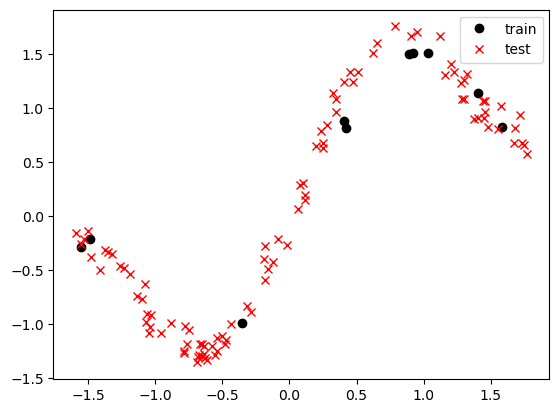

In [173]:
def get_batch_data(b, task, batch_size):
    Xtr, ytr, Xte, yte, train_loader = get_task_data(task)

    ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
    print(ndx_train)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
 
    dataset = data.TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
    Ntr  = Xtr.shape[0] # full batch
    loader = data.DataLoader(dataset, batch_size=Ntr)
    return Xtr, ytr, Xte, yte, loader

Xtr, ytr, Xte, yte, train_loader = get_batch_data(5, 0, 10)
print(Xtr.shape, Xte.shape)
plot_data(Xtr, ytr, Xte, yte)

In [183]:
import rebayes

ModuleNotFoundError: No module named 'rebayes'

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]


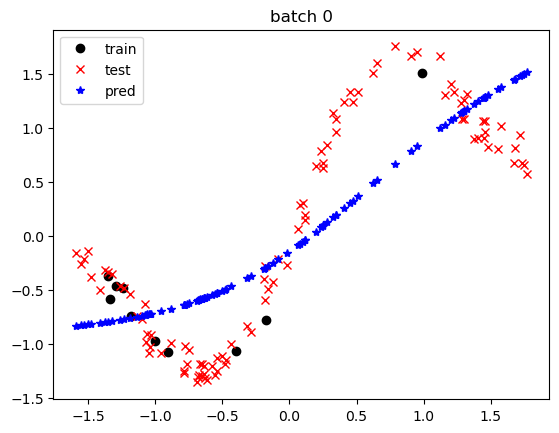

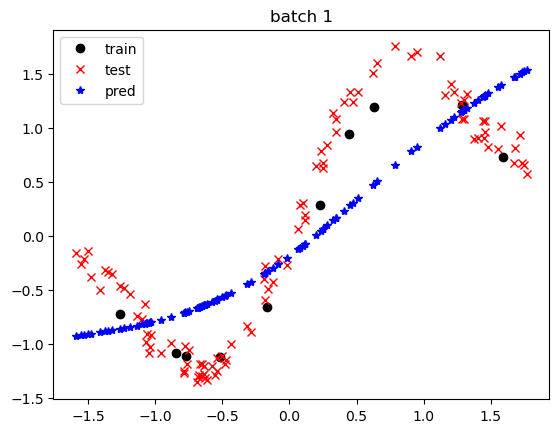

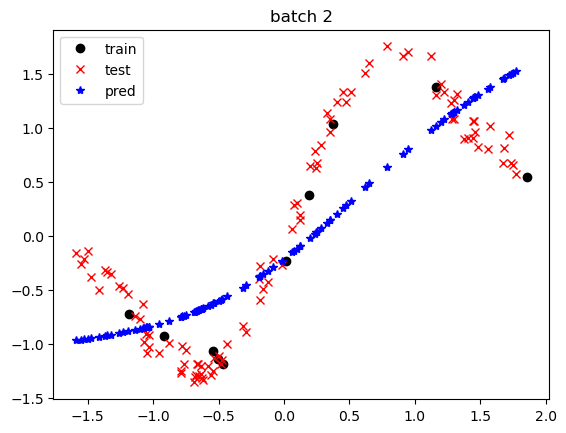

In [179]:

pyro.clear_param_store()
task = 0
bs = 10
nepochs = 1000
bnn = make_bnn()
for b in range(3):
    Xtr, ytr, Xte, yte, train_loader = get_batch_data(b, task, bs)
    #plot_data(Xtr, ytr, Xte, yte)
    bnn, elbos = train_bnn(bnn, train_loader, nepochs)
    plot_pred(bnn, Xtr, ytr, Xte, yte, 'batch {:d}'.format(b))
    bnn = update_prior(bnn)

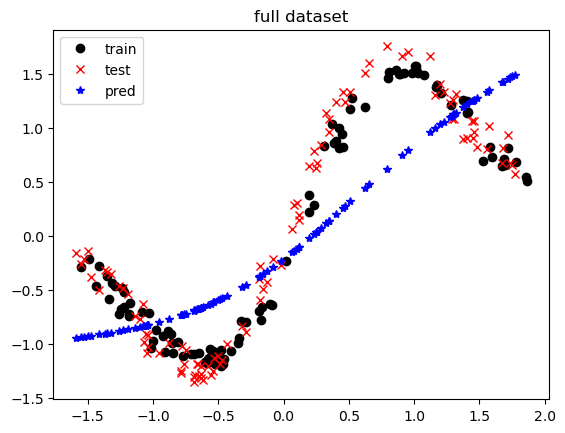

In [180]:
Xtr, ytr, Xte, yte, train_loader = get_task_data(task)
plot_pred(bnn, Xtr, ytr, Xte, yte, 'full dataset')

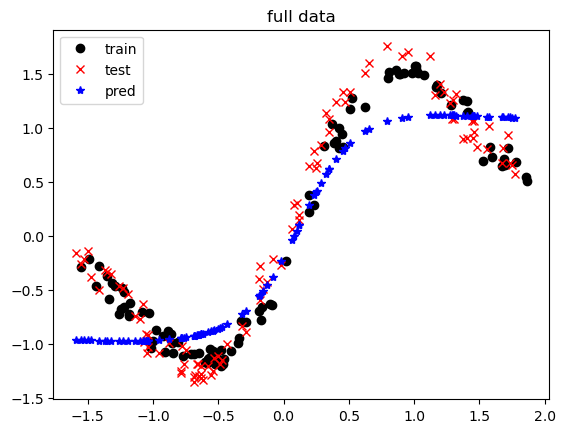

In [182]:
pyro.clear_param_store()
task = 0
bs = 10
nepochs = 10000
bnn = make_bnn()
Xtr, ytr, Xte, yte, train_loader = get_task_data(task)
bnn, elbos = train_bnn(bnn, train_loader, nepochs)
plot_pred(bnn, Xtr, ytr, Xte, yte, 'full data')
